# Predicción de rentabilidad en yacimientos petroleros — OilyGiant

## Contenido

* [Introducción](#intro)  
* [1. Descripción y preparación de los datos](#data_review)
* [2. Análisis exploratorio de los datos](#data_analysis)
    * [2.1. Producción de las regiones](#production_analysis)
    * [2.2. Características de las regiones](#features_analysis)
* [3. Entrenamiento del modelo predictivo](#model_prediction)
    * [3.1. Definición de características/objetivo y segmentando en conjuntos de entrenamiento y validación](#features_target)
    * [3.2. Entrenamiento del modelo y predicciones del conjunto de validación](#train_predict)
    * [3.3. Evaluación del modelo](#eval)
    * [3.4. Resultados de cada región](#model_results)
* [4. Cálculo de ganancias](#revenue)
* [5. Riesgos y aleatoriedad](#risks)
* [Conclusiones](#end)

## Introducción <a id="intro"></a>

El objetivo es encontrar los mejores lugares donde abrir 200 pozos nuevos de petróleo. Se tienen datos sobre muestras de crudo de tres regiones. Ya se conocen los parámetros de cada pozo petrolero de la región. Crea un modelo que ayude a elegir la región con el mayor margen de beneficio. Se desea analizar los beneficios y riesgos potenciales utilizando la técnica bootstrapping.

### Condiciones:

- Solo se debe usar la regresión lineal para el entrenamiento del modelo.
- Al explorar una región, se lleva a cabo un estudio de 500 puntos con la selección de los mejores 200 puntos para el cálculo del beneficio.
- El presupuesto para el desarrollo de 200 pozos petroleros es de 100 millones de dólares.
- Un barril de materias primas genera 4.5 USD de ingresos. El ingreso de una unidad de producto es de 4500 dólares (el volumen de reservas está expresado en miles de barriles).
- Realizar una evaluación de riesgo, manteniendo solo las regiones con riesgo de pérdidas inferior al 2.5%. De las que se ajustan a los criterios, se debe seleccionar la región con el beneficio promedio más alto.

### Descripción de datos

Los datos de exploración geológica de las tres regiones se almacenan en archivos: /datasets/geo_data_0.csv, /datasets/geo_data_1.csv y /datasets/geo_data_2.csv. 

- id — identificador único de pozo de petróleo
- f0, f1, f2 — tres características de los puntos (su significado específico no es importante, pero las características en sí son significativas)
- product — volumen de reservas en el pozo de petróleo (miles de barriles).

Los detalles del contrato y las características del pozo no se publican.

## 1. Descripción y preparación de los datos. <a id="data_review"></a>

Iniciamos el estudio extrayendo los datos separados en las 3 regiones distintas y observando las propiedades de los mismos.

In [1]:
# Importando las librerías necesarias para el estudio.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error

In [2]:
# Traer los datos de la primera región y observar su contenido.
geo_0 = pd.read_csv('/datasets/geo_data_0.csv')
geo_0.head()

,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


In [3]:
# Traer los datos de la segundo región y observar su contenido.
geo_1 = pd.read_csv('/datasets/geo_data_1.csv')
geo_1.head()

,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305


In [4]:
# Traer los datos de la tercera región y observar su contenido.
geo_2 = pd.read_csv('/datasets/geo_data_2.csv')
geo_2.head()

,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746


In [5]:
# Observamos la información de las columnas y el tipo de datos de la región 0.
print(geo_0.info())

# Revisamos las estadísticas descriptivas de la región 0.
geo_0.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
None


,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.500419,0.250143,2.502647,92.500000
std,0.871832,0.504433,3.248248,44.288691
min,-1.408605,-0.848218,-12.088328,0.000000
25%,-0.072580,-0.200881,0.287748,56.497507
50%,0.502360,0.250252,2.515969,91.849972
75%,1.073581,0.700646,4.715088,128.564089
max,2.362331,1.343769,16.003790,185.364347


In [6]:
# Observamos la información de las columnas y el tipo de datos de la región 1.
print(geo_1.info())

# Revisamos las estadísticas descriptivas de la región 1.
geo_1.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
None


,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,1.141296,-4.796579,2.494541,68.825000
std,8.965932,5.119872,1.703572,45.944423
min,-31.609576,-26.358598,-0.018144,0.000000
25%,-6.298551,-8.267985,1.000021,26.953261
50%,1.153055,-4.813172,2.011479,57.085625
75%,8.621015,-1.332816,3.999904,107.813044
max,29.421755,18.734063,5.019721,137.945408


In [7]:
# Observamos la información de las columnas y el tipo de datos de la región 2.
geo_2.info()

# Revisamos las estadísticas descriptivas de la región 2.
geo_2.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.002023,-0.002081,2.495128,95.000000
std,1.732045,1.730417,3.473445,44.749921
min,-8.760004,-7.084020,-11.970335,0.000000
25%,-1.162288,-1.174820,0.130359,59.450441
50%,0.009424,-0.009482,2.484236,94.925613
75%,1.158535,1.163678,4.858794,130.595027
max,7.238262,7.844801,16.739402,190.029838


No hay presencia de datos nulos, ni inconsistencias en el tipo de datos. Las características f0, f1 y f2 se encuentran ya escaladas, por lo que no se requiere realizar ninguna preparación en los datos.

## 2. Análisis exploratorio de los datos. <a id="data_analysis"></a>

Abarcaremos un análisis sencillo de los datos, ya que no es el objetivo principal del proyecto, simplemente observando la distribución de la producción en cada región, y la distribución de sus características.

### 2.1. Producción de las regiones. <a id="production_analysis"></a>

In [8]:
# Extraemos la produción de cada región.
geo_0_prod = geo_0['product']
geo_1_prod = geo_1['product']
geo_2_prod = geo_2['product']

# Construimos un DataFrame con los resultados de producción.
production_df = pd.concat([geo_0_prod, geo_1_prod, geo_2_prod], axis=1)
production_df.columns = ['product_0', 'product_1', 'product_2']
production_df

,product_0,product_1,product_2
0,105.280062,3.179103,27.758673
1,73.037750,26.953261,56.069697
2,85.265647,134.766305,62.871910
3,168.620776,137.945408,114.572842
4,154.036647,134.766305,149.600746
...,...,...,...
99995,110.744026,53.906522,172.327046
99996,122.346843,137.945408,138.748846
99997,64.375443,137.945408,157.080080
99998,74.040764,30.132364,51.795253


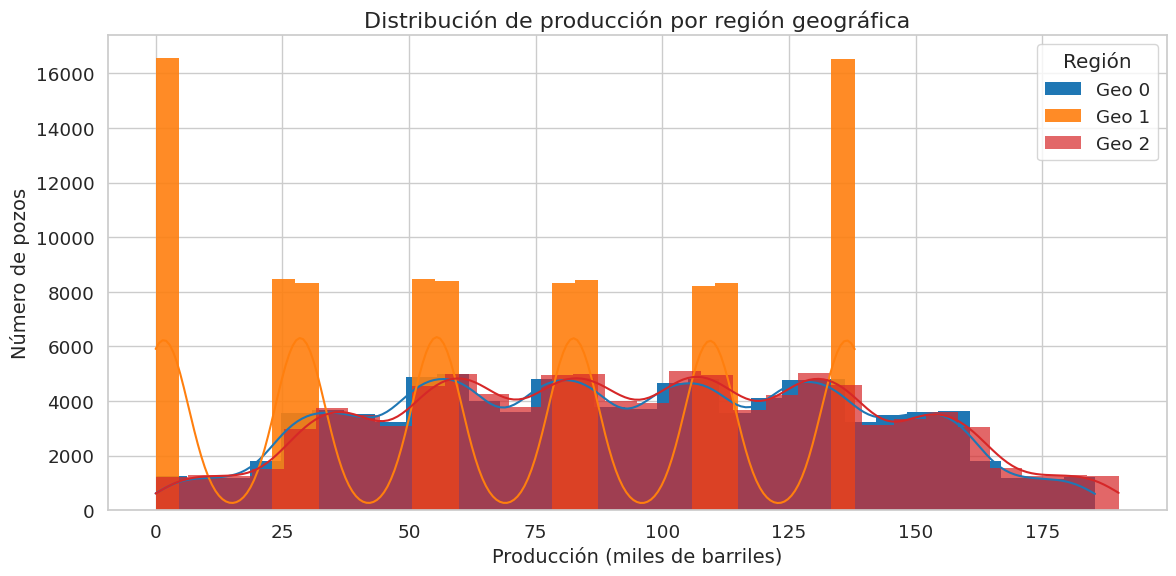

In [9]:
# Preparamos las configuraciones del gráfico para la producción.
sns.set(style='whitegrid', font_scale=1.2)
plt.figure(figsize=(12, 6))

# Creamos los histogramas por región.
sns.histplot(production_df['product_0'], kde=True, color='#1f77b4', label='Geo 0', alpha=1, bins=30, linewidth=0)
sns.histplot(production_df['product_1'], kde=True, color='#ff7f0e', label='Geo 1', alpha=0.9, bins=30, linewidth=0)
sns.histplot(production_df['product_2'], kde=True, color='#d62728', label='Geo 2', alpha=0.7, bins=30, linewidth=0)

# Configuramos los títulos y etiquetas.
plt.title('Distribución de producción por región geográfica', fontsize=16)
plt.xlabel('Producción (miles de barriles)', fontsize=14)
plt.ylabel('Número de pozos', fontsize=14)

# Escribimos la leyenda.
plt.legend(title='Región')
plt.tight_layout()
plt.show()

En las estadísticas descriptivas evidenciamos que la producción de las tres regiones poseen una desviación estándar muy similar (~45), sin embargo, a pesar de que todos describen una alta dispersión de sus datos, se puede describir su distribución en dos comportamientos definidos por el histograma. 

- El primer tipo de comportamiento al cual pertenecen las regiones 0 y 2 (azul y rojo) es una producción con una moda poco definida y múltiples valores de producción (desde 0 hasta 190 unidades) con una concentración de pozos en un rango muy amplio (entre 50 y 140 unidades) lo que le da una forma de meseta plana, baja y ancha.

- El segundo tipo de comportamiento, observado en la región 1 con el color amarillo, nos muestra picos claros con modas alrededor de sus extremos (0 y 138) y adicionalmente grupos de pozos con producciones muy bien definidas otorgando la forma de torres aisladas en la distribución, cada torre simboliza un grupo de pozos.

### 2.2. Características de las regiones. <a id="features_analysis"></a>

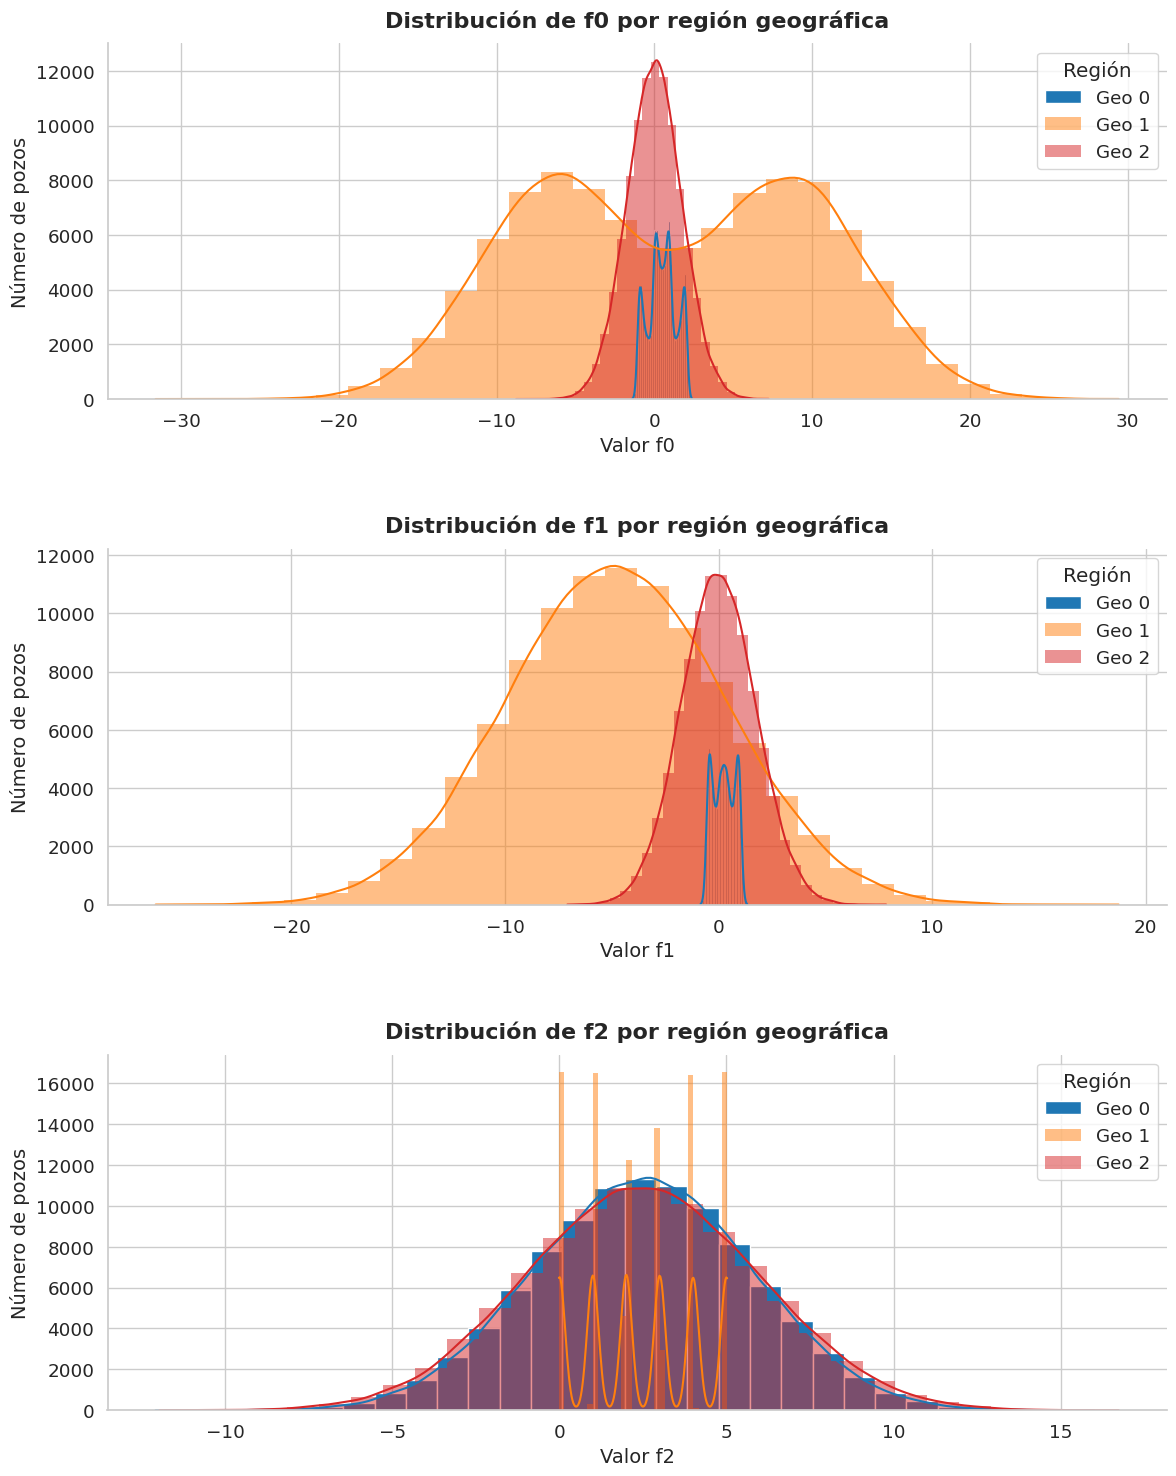

In [10]:
# Preparamos las configuraciones del gráfico de las características.
fig, axes = plt.subplots(3, 1, figsize=(12, 15))
axes = axes.flatten()
columns = ['f0', 'f1', 'f2']

# Iteramos por cada columnas (característica) y graficamos las regiones.
for i, col in enumerate(columns):
    sns.histplot(geo_0[col], kde=True, ax=axes[i], color='#1f77b4', label='Geo 0', alpha=1, bins=30, linewidth=1)
    sns.histplot(geo_1[col], kde=True, ax=axes[i], color='#ff7f0e', label='Geo 1', alpha=0.5, bins=30, linewidth=0)
    sns.histplot(geo_2[col], kde=True, ax=axes[i], color='#d62728', label='Geo 2', alpha=0.5, bins=30, linewidth=0)
    
    # Incluimos títulos y etiquetas.
    axes[i].set_title(f'Distribución de {col} por región geográfica', fontsize=16, fontweight='bold', pad=12)
    axes[i].set_xlabel(f'Valor {col}', fontsize=14)
    axes[i].set_ylabel('Número de pozos', fontsize=14)    
    axes[i].legend(title='Región')
    
    # Ajustamos los bordes
    sns.despine(ax=axes[i])

# Ajustamos el espaciado entre subplots
plt.tight_layout(h_pad=3.0, w_pad=2.0)
plt.show()

En la distribución de las características de los pozos en cada región, también se pueden agrupar en dos tendencias, la región 0 y 2 mostrando un comportamiento similar, mientras que la región 1 diferenciándose, puede que sea esta la razón de los comportamientos y sus diferencias en la distribución de producción de cada región.

En futuros estudios y teniendo mayor información de la naturaleza y la propiedad que describe cada característica podríamos llegar a nuevos hallazgos y conclusiones.

## 3. Entrenamiento del modelo predictivo. <a id="model_prediction"></a>

Se entrenarán 3 modelos predictivos, uno para cada región, haciendo uso de un modelo de regresión lineal para cada uno. Esto nos permitirá determinar la producción con base en sus tres características (f0, f1 y f2). Como mencionamos en la preparación de los datos, los valores de las características ya tienen una estandarización, ya que sus valores no tienen escalas muy diferentes, por lo que no se requerirá aplicar este proceso.

Definiremos el proceso de crear el modelo a través de funciones para asegurar reproducibilidad y evitar duplicidad de código al aplicarlo a cada región.

### 3.1. Definición de características/objetivo y segmentando en conjuntos de entrenamiento y validación. <a id="features_target"></a>

Las características del modelo serán las columnas f0, f1 y f2. La columna id no aporta información relevante del comportamiento del pozo al modelo, por eso será descartada. El objetivo de predicción del modelo será la producción en miles de barriles.

También dividiremos el grupo de datos de cada región en dos, un 75% para el entrenamiento de su propio modelo y un 25% para validarlo.

In [11]:
# Definiendo  las características y el objetivo y segmentando los conjuntos de datos.
def segment_dataset(geo_data):     
    """
    Esta función selecciona las columnas 'f0', 'f1' y 'f2' como características (features)
    y la columna 'product' como variable objetivo. Luego, realiza una partición del 
    conjunto de datos en subconjuntos de entrenamiento y validación con una proporción 
    del 75% para entrenamiento y 25% para validación.

    Args:
        geo_data (pandas.DataFrame): 
            Conjunto de datos que contiene las columnas 'f0', 'f1', 'f2' y 'product'.

    Returns:
        Tuple[pandas.DataFrame, pandas.DataFrame, pandas.Series, pandas.Series]: 
            Una tupla con los siguientes elementos:
            - X_train: Características del conjunto de entrenamiento.
            - X_valid: Características del conjunto de validación.
            - y_train: Variable objetivo del conjunto de entrenamiento.
            - y_valid: Variable objetivo del conjunto de validación.
    """
    features = geo_data[['f0', 'f1', 'f2']]
    target = geo_data['product']    
    
    return train_test_split(features, target, test_size=0.25, random_state=12345)

### 3.2. Entrenamiento del modelo y predicciones del conjunto de validación. <a id="train_predict"></a>

Este paso se centrará en definir una función. Esta se encargará de entrenar el modelo de regresión linear y predecir los valores de producción para el conjunto de validación.

In [12]:
# Definiendo el entrenamiento y predicción del modelo.
def predict_with_linear_regression_model(features_train, features_valid, target_train, target_valid):
    """
    Esta función ajusta un modelo de regresión lineal utilizando las características y el objetivo
    del conjunto de entrenamiento. Luego, predice los valores de la variable objetivo en el conjunto 
    de validación y devuelve las predicciones como una serie de pandas, utilizando el mismo índice 
    que `target_valid` para mantener la coherencia en la alineación.

    Args:
        features_train (pandas.DataFrame): 
            Conjunto de características para el entrenamiento.
        features_valid (pandas.DataFrame): 
            Conjunto de características para la validación.
        target_train (pandas.Series): 
            Valores reales de la variable objetivo para el entrenamiento.
        target_valid (pandas.Series): 
            Valores reales de la variable objetivo para la validación, utilizado para definir el índice de salida.

    Returns:
        pandas.Series: 
            Serie de predicciones del modelo para el conjunto de validación, alineadas con el índice de `target_valid`.
    """
    model = LinearRegression()
    model.fit(features_train, target_train)
    predictions = model.predict(features_valid)
    
    predictions = pd.Series(predictions, index=target_valid.index, name='predictions')
    
    return predictions

### 3.3. Evaluación del modelo. <a id="eval"></a>

Para asegurar que los modelos son competentes en la predicción del objetivo, los evaluaremos frente a las métricas: raíz cuadrada del error cuadrático medio (RMSE), el coeficiente de determinación (R2) y el error absoluto medio (MAE). También los compararemos con modelos de control que predicen el promedio y la mediana de cada región a cada pozo con el fin de reconocer su desempeño.

La primera función de esta sección está dedicada a evaluar cada métrica en el modelo, mientras que la segunda a obtener las métricas de control para cada conjunto. Al final de la sección, una tabla resumirá los cálculos de cada función para poder comparar resultados.

In [13]:
# Identificando las métricas del modelo.
def evaluate_predictions_performance(target_valid, predictions):
    """
    Calcula el promedio de las predicciones, el error cuadrático medio (RMSE), el coeficiente de determinación (R²)
    y el error absoluto medio (MAE), comparando las predicciones con los valores reales.

    Args:
        target_valid (pandas.Series o numpy.ndarray): 
            Valores reales de la variable objetivo en el conjunto de validación.
        predictions (pandas.Series o numpy.ndarray): 
            Predicciones generadas por el modelo para el conjunto de validación.

    Returns:
        Tuple[float, float, float, float]: 
            Una tupla con las siguientes métricas:
            - mean: Promedio de las predicciones.
            - RMSE: Raíz del error cuadrático medio.
            - R2: Coeficiente de determinación (R²).
            - MAE: Error absoluto medio.
    """
    mean = predictions.mean()
    RMSE = mean_squared_error(target_valid, predictions, squared=False)
    R2 = r2_score(target_valid, predictions)
    MAE = mean_absolute_error(target_valid, predictions)

    return mean, RMSE, R2, MAE

In [14]:
# Identificando metricas de control para la comparación.
def get_control_metrics(target_valid):
    """
    Esta función utiliza predicciones constantes basadas en el valor medio y la mediana del conjunto
    de validación para estimar métricas de control. Estas métricas sirven como punto de comparación 
    frente al desempeño de modelos predictivos.

    Args:
        target_valid (pandas.Series): 
            Valores reales de la variable objetivo en el conjunto de validación.

    Returns:
        Tuple[float, float, float]: 
            Una tupla con las siguientes métricas de referencia:
            - control_mean: Promedio de los valores reales (utilizado como predicción constante).
            - control_RMSE: Raíz del error cuadrático medio al predecir siempre con el promedio.
            - control_MAE: Error absoluto medio al predecir siempre con la mediana.
    """
    control_mean = target_valid.mean()    
    mean_predictions = pd.Series(control_mean, index=target_valid.index)
    control_RMSE = mean_squared_error(target_valid, mean_predictions, squared=False)

    control_median= target_valid.median()
    median_prediction = pd.Series(control_median, index=target_valid.index)
    control_MAE = mean_absolute_error(target_valid, median_prediction)
    
    return control_mean, control_RMSE, control_MAE

### 3.4. Resultados de cada región. <a id="model_results"></a>

A continuación, ejecutaremos los procesos definidos para cada región en un bucle y registraremos los resultados de sus métricas en un dataframe, también las predicciones y los valores reales de cada conjunto de validación para próximos análisis.

In [15]:
# Variables que almacenarán los resultados.
df_metrics = pd.DataFrame()
geo_predictions = []
geo_targets = []

# Iteración sobre cada región.
dataset_name = ['geo_0', 'geo_1', 'geo_2']
for i, dataset in enumerate([geo_0, geo_1, geo_2]):
    
    # Definición de características/objetivo y segmentando en conjuntos de entrenamiento y validación.
    features_train, features_valid, target_train, target_valid = segment_dataset(dataset)
    geo_targets.append(target_valid)

    # Entrenamiento del modelo y predicciones del conjunto de validación. 
    predictions = predict_with_linear_regression_model(features_train, features_valid, target_train, target_valid)    
    geo_predictions.append(predictions)

    # Evaluación del modelo.
    mean, RMSE, R2, MAE = evaluate_predictions_performance(target_valid, predictions)

    # Evaluación modelo de control.
    control_mean, control_RMSE, control_MAE = get_control_metrics(target_valid)

    # Almacenando los resultados de metricas.
    row = pd.DataFrame({
    'dataset': dataset_name[i],
    'mean': mean,
    'control_mean': control_mean,
    'RMSE': RMSE,
    'control_RMSE': control_RMSE,
    'R2': R2,
    'MAE': MAE,
    'control_MAE': control_MAE
    }, index=[i]) 

    df_metrics = pd.concat([df_metrics, row])

In [16]:
# Observamos los resultados de las metricas de los modelos en cada región.
df_metrics

,dataset,mean,control_mean,RMSE,control_RMSE,R2,MAE,control_MAE
0,geo_0,92.592568,92.078597,37.579422,44.286027,0.279943,30.919601,37.665591
1,geo_1,68.728547,68.723136,0.893099,46.021245,0.999623,0.718766,40.265479
2,geo_2,94.965046,94.884233,40.029709,44.902084,0.205248,32.792652,37.920986


Los resultados de las métricas de los modelos son muy positivos.

- En primer lugar, la media de todos los modelos se aproxima muy bien a la media real del conjunto en todos los casos.
- Para la región 0 y 2 notamos un valor RMSE algo elevado; sin embargo, su desempeño es mejor que el control, lo que nos da una buena señal de que el modelo está realizando mejores predicciones que solo ajustar la media a las predicciones, el R2 de estos grupos refleja esta misma conclusión, sin embargo, nos muestra que la región 0 está mostrando un mejor desempeño en el cálculo de las predicciones que la región 2.
- La región 1 mostró el mejor desempeño en el cálculo de predicciones, con un RMSE increíblemente bajo y un R2 casi perfecto (1). Este modelo destacó sobre las otras dos regiones, por lo que podemos confiar bastante en las predicciones que realice de esta región.
- Finalmente, el MAE nos confirma todas las conclusiones previas en donde los modelos de las regiones 0 y 2 lo hacen mejor que la predicción de control y el modelo de la región 1 hace predicciones con márgenes de error muy bajos.

## 4. Cálculo de ganancias. <a id="revenue"></a>

Dada la inversión de 100 millones por 200 pozos petrolíferos, de media un pozo petrolífero debe producir al menos un valor de 500,000 dólares en unidades para evitar pérdidas (esto es equivalente a 111.1 unidades).

In [35]:
# Variables a considerar.
barrel_usd = 4.5
wells_num = 200
budget = 100000000

# Promedio de producción esperado para evitar pérdidas.
production_hope = budget / (wells_num * barrel_usd * 1000)
print(f'La media de producción esperada por región para evitar perdidas es de {production_hope:.6f} miles de barriles.')

La media de producción esperada por región para evitar perdidas es de 111.111111 miles de barriles.


In [18]:
# Cantidad promedio predicha en cada región.
for i, mean in enumerate(df_metrics['mean']):
    print(f'El promedio de la región {i} es {mean}')

El promedio de la región 0 es 92.59256778438035
El promedio de la región 1 es 68.728546895446
El promedio de la región 2 es 94.96504596800489


Al comparar los promedios de todas la región no tenemos un buen indicio de que las regiones serán rentables para las condiciones dadas, sin embargo, la dispersión de la producción de los pozos es alta en las tres regiones implicando valores bastante alejados de la media, esto significa que esta herramienta no es la mejor para determinar la rentabilidad o generalizar un comportamiento de los pozos. Aun así, podemos revisar la producción promedio de los 200 pozos más productivos en cada región que fueron determinados por los modelos predictivos, para ello haremos uso de esta función.

In [19]:
# Producción promedio predicha de los pozos más productivos y ganacias.
def wells_revenue(target, predictions, wells_num, barrel_usd, return_prod=False):
    """
    Esta función selecciona los `wells_num` pozos con mayor producción predicha, calcula la producción 
    real de esos pozos y estima las ganancias totales en función del precio del barril de petróleo. 
    Opcionalmente, puede devolver también la serie de producciones reales seleccionadas.

    Args:
        target (pandas.Series): 
            Producción real de cada pozo.
        predictions (pandas.Series): 
            Producción predicha de cada pozo.
        wells_num (int): 
            Número de pozos a seleccionar con mayor producción predicha.
        barrel_usd (float): 
            Precio en dólares por cada barril de petróleo (multiplicado por 1000).
        return_prod (bool, optional): 
            Si es True, también se devuelve la producción real de los pozos seleccionados. 
            Por defecto es False.

    Returns:
        float o Tuple[pandas.Series, float]: 
            - Si `return_prod` es False: retorna solo las ganancias estimadas (float).
            - Si `return_prod` es True: retorna una tupla con:
                - Serie con la producción real de los pozos seleccionados.
                - Ganancias estimadas (float).
    """
    predicted_wells = predictions.sort_values(ascending=False)
    production = target[predicted_wells.index][:wells_num] 
    total_revenue = barrel_usd*1000*production.sum()
    
    if return_prod:
        return production, total_revenue
    else:
        return total_revenue

In [29]:
# Iteración en cada región para determinar los resultados de los pozos más productivos.
for i, target, predictions in zip(range(len(geo_targets)), geo_targets, geo_predictions):
    #Cálculo de la producción y ganancias
    prod_list, revenue = wells_revenue(target, predictions, wells_num, barrel_usd, return_prod=True)

    # Impresión de resultados
    print(f'Región {i}:')
    print(f'- El promedio de producción de los {wells_num} pozos más productivos es {prod_list.mean():.6f} miles de barriles.')
    print(f'- El total de reservas en los {wells_num} pozos más productivos es de {prod_list.sum():.6f} miles de barriles.')
    print(f'- La ganancia obtenida es de ${revenue:.2f}.')
    print()

Región 0:
- El promedio de producción de los 200 pozos más productivos es 148.009178 miles de barriles.
- El total de reservas en los 200 pozos más productivos es de 29601.835651 miles de barriles.
- La ganancia obtenida es de $133208260.43.

Región 1:
- El promedio de producción de los 200 pozos más productivos es 137.945408 miles de barriles.
- El total de reservas en los 200 pozos más productivos es de 27589.081548 miles de barriles.
- La ganancia obtenida es de $124150866.97.

Región 2:
- El promedio de producción de los 200 pozos más productivos es 141.226111 miles de barriles.
- El total de reservas en los 200 pozos más productivos es de 28245.222141 miles de barriles.
- La ganancia obtenida es de $127103499.64.



Esta perspectiva cambia completamente las conclusiones que habíamos determinado pasos antes, ahora todas las regiones parecen rentables, siendo la **región 0** la más atractiva por tener el mayor beneficio monetario.

Para aproximar más nuestro experimento a una situación real, se nos menciona que al explorar una región se lleva a cabo un estudio de tan solo 500 puntos de los cuales debemos elegir los mejores para llevar a producción, es por eso que no podemos elegir los mejores pozos de todo nuestro conjunto de datos sino que debemos seleccionar un subconjunto aleatorio de 500 pozos para realizar este estudio.

In [28]:
# Variable para almacenar resultados de la simulación.
geo_revenue_simulation = []

# Iteración en cada región para determinar los resultados de la simulación.
for i, target, predictions in zip(range(len(geo_targets)), geo_targets, geo_predictions):
    
    target_subsample = target.sample(n=500, replace= True, random_state=12345)
    predic_subsample = predictions[target_subsample.index]
    
    #Cálculo de la producción y ganancias
    prod_list, revenue = wells_revenue(target_subsample, predic_subsample, wells_num, barrel_usd, return_prod=True)
    
    #Almacenando los resultados en variables.
    geo_revenue_simulation.append(revenue)

    # Impresión de resultados
    print(f'Región {i}:')
    print(f'- El promedio de producción de los {wells_num} pozos más productivos es {prod_list.mean():.6f} miles de barriles.')
    print(f'- El total de reservas en los {wells_num} pozos más productivos es de {prod_list.sum():.6f} miles de barriles.')
    print(f'- La ganancia obtenida es de ${revenue:.2f}.')
    print()

Región 0:
- El promedio de producción de los 200 pozos más productivos es 117.612100 miles de barriles.
- El total de reservas en los 200 pozos más productivos es de 23522.419992 miles de barriles.
- La ganancia obtenida es de $105850889.96.

Región 1:
- El promedio de producción de los 200 pozos más productivos es 114.437326 miles de barriles.
- El total de reservas en los 200 pozos más productivos es de 22887.465271 miles de barriles.
- La ganancia obtenida es de $102993593.72.

Región 2:
- El promedio de producción de los 200 pozos más productivos es 110.055065 miles de barriles.
- El total de reservas en los 200 pozos más productivos es de 22011.012940 miles de barriles.
- La ganancia obtenida es de $99049558.23.



El resultado de nuestro experimento difirió en gran medida con las observaciones que teníamos realizando el proceso con un conjunto amplio de datos. Aquí podemos observar que solo dos regiones llegan a tener ganancias (región 0 y 1), mientras que la región 2 presenta pérdidas. Esto se debe a la aleatoriedad de seleccionar 500 pozos exploratorios.

Nuevamente, la **región 0** se postula como la más atractiva, pero revisemos si esto no es realmente producto de la misma aleatoriedad que descartó a la región 2 como región rentable.

## 5. Riesgos y aleatoriedad. <a id="risks"></a>

A pesar de que los cálculos puedan parecer atrayentes hacia la región 0, debemos tener otro factor en cuenta en este estudio: la aleatoriedad dada en la selección de las muestras para estos cálculos. Debemos asegurar que estos resultados no son fuente de una situación idónea o poco probable. Para ello haremos uso de la técnica de bootstrapping.

Con ella determinaremos un intervalo de confianza del 95% para la producción promedio de los 200 pozos, teniendo en cuenta que al explorar una región se toman 500 puntos de muestreo. También determinaremos la probabilidad de generar pérdidas bajo estas condiciones en cada región.

In [26]:
# Definimos la aplicación de la técnica de bootstrapping.
def bootstrapping(target_sample, predic_sample, num_iter):  
    """
    Esta función realiza múltiples simulaciones aleatorias (con reemplazo) del conjunto de datos,
    estimando los ingresos obtenidos por seleccionar los pozos más productivos en cada iteración.
    
    Args:
        target_sample (pandas.Series): 
            Producción real de cada pozo.
        predic_sample (pandas.Series): 
            Producción predicha de cada pozo.
        num_iter (int): 
            Número de iteraciones (simulaciones) para aplicar bootstrapping.

    Returns:
        pandas.Series: 
            Serie con los ingresos obtenidos en cada iteración de bootstrapping.
    """
    state = np.random.RandomState(12345)
    values = []
    
    for i in range(num_iter):
        target_subsample = target_sample.sample(n=500, replace= True, random_state=state)
        predic_subsample = predic_sample[target_subsample.index]
        
        values.append(wells_revenue(target_subsample, predic_subsample, wells_num, barrel_usd))
    
    values = pd.Series(values)

    return values

In [27]:
# Una variable para almacenar los resultados del bootstrapping.
bootstrap_revenues = []
simulations = 1000

# Aplicamos la técnica realizando 1000 simulaciones como las que realizamos previamente.
for i, target, predictions in zip(range(len(geo_targets)), geo_targets, geo_predictions):
    #Aplicamos la técnica.
    revenues = bootstrapping(target, predictions, simulations)
    
    # Se almacena los resultados del bootstrapping.
    bootstrap_revenues.append(revenues)

    # Identificamos el promedio de las simulaciones.
    revenues_mean = revenues.mean()

    # Marcamos el intervalo de confianza del 95%.
    lower_interval = revenues.quantile(0.025)
    upper_interval = revenues.quantile(0.975)

    # Identificamos el riesgo de pérdidas.
    risk = len(revenues[revenues<budget]) / len(revenues)

    # Impresión de resultados
    print(f"Región {i}:")    
    print(f"Ingresos promedio: ${revenues_mean:.2f}.")
    print(f"Intervalo de confianza del 95%: (${lower_interval:.2f}, ${upper_interval:.2f}).")
    print(f"Riesgo de pérdidas: {risk*100}%")
    print()    

Región 0:
Ingresos promedio: $104259385.27.
Intervalo de confianza del 95%: ($98979099.05, $109479763.53).
Riesgo de pérdidas: 6.0%

Región 1:
Ingresos promedio: $105152227.73.
Intervalo de confianza del 95%: ($100688732.25, $109315475.91).
Riesgo de pérdidas: 1.0%

Región 2:
Ingresos promedio: $104350083.63.
Intervalo de confianza del 95%: ($98711194.53, $109697069.54).
Riesgo de pérdidas: 6.4%



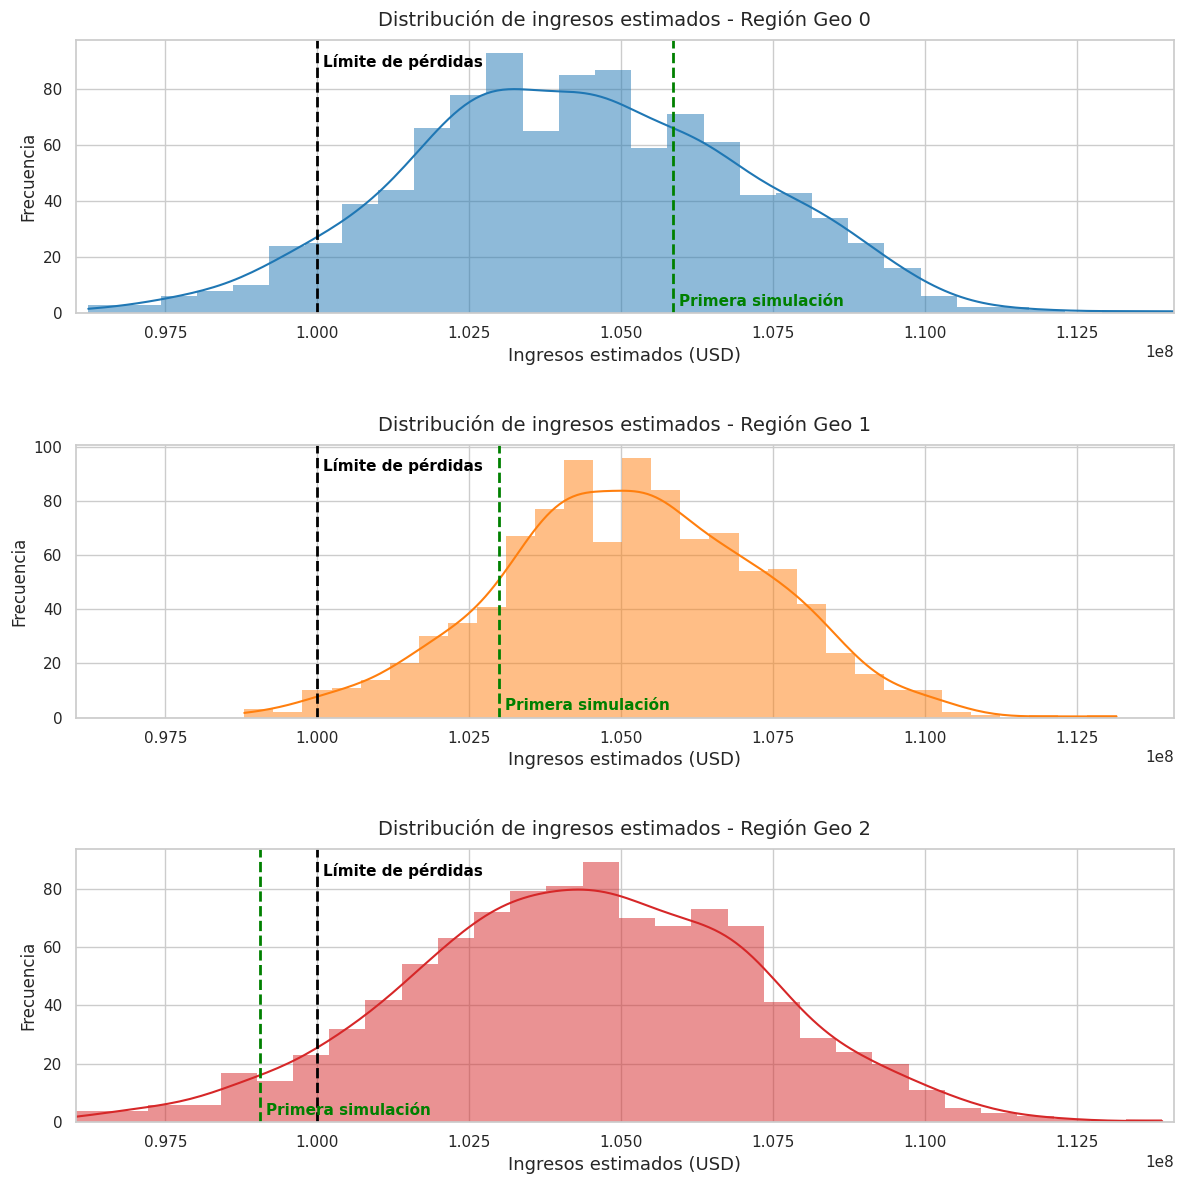

In [45]:
# Visualización de la distribución de ganancias resultado del bootstrapping para cada región.
# Configuramos estilo general.
sns.set(style='whitegrid', context='notebook')
colors = ['#1f77b4', '#ff7f0e', '#d62728']
labels = ['Geo 0', 'Geo 1', 'Geo 2']

# Calculamos los límites comunes del eje X
xmin = min(series.min() for series in bootstrap_revenues)
xmax = max(series.max() for series in bootstrap_revenues)

# Crear subplots.
fig, axes = plt.subplots(3, 1, figsize=(12, 12))

# Iterar sobre cada conjunto de resultados.
for i in range(3):
    # Histograma de la distribución probable de las ganancias.
    sns.histplot(bootstrap_revenues[i], kde=True, color=colors[i], ax=axes[i], bins=30, linewidth=0)

    # Línea vertical del límite de pérdidas.
    axes[i].axvline(budget, color='black', linestyle='--', linewidth=2)

    # Línea vertical de la primera simulación.
    axes[i].axvline(geo_revenue_simulation[i], color='green', linestyle='--', linewidth=2)
    
    # Etiqueta del límite de pérdidas.
    axes[i].text(budget*1.001, axes[i].get_ylim()[1] * 0.95, 'Límite de pérdidas', 
                 color='black', fontsize=11, ha='left', va='top', fontweight='bold')
    
    # Etiqueta de la simulación.
    axes[i].text(geo_revenue_simulation[i]*1.001, axes[i].get_ylim()[1] * 0.07, 'Primera simulación', 
                 color='green', fontsize=11, ha='left', va='top', fontweight='bold')

    # Títulos y etiquetas
    axes[i].set_title(f'Distribución de ingresos estimados - Región {labels[i]}', fontsize=14, pad=10)
    axes[i].set_ylabel('Frecuencia', fontsize=12)
    axes[i].set_xlabel('Ingresos estimados (USD)', fontsize=13)

    # Alineación del eje X
    axes[i].set_xlim(xmin, xmax)

# Ajuste del layout
plt.tight_layout(h_pad=3.0)
plt.show()

En esta visualización podemos apreciar cómo nuestra primera simulación fue a causa de situaciones favorables en algunas regiones y desfavorables en otras. Por ejemplo, en el caso de la región 0 la cual fue nuestra región elegida como favorita en la primera simulación notamos que la aleatoriedad le otorgo la situación más favorable de las 3, mientras que en la región 2 la cual llegamos a descartar por registrar pérdidas obtuvo una selección de muestras muy desfavorable y con baja probabilidad de ocurrencia (debido a que está muy sesgada a la izquierda). Esta es la razón principal por la que se recomienda aplicar técnicas como el bootstrapping a este tipo de análisis, para evitar tomar decisiones sobre situaciones poco probables (muy favorables o muy desfavorables).

Para poder elegir una región también debemos usar el criterio de que esta no debe representar riesgos de perdidas mayores al 2.5%, automáticamente descartaremos la región 0 y 2 por tener riesgos de perdidas del 6% y 6.4% respectivamente, esto lo podemos evidenciar también en nuestra visualización, ya que estas dos regiones poseen una mayor cantidad de área del histograma del lado izquierdo del límite de pérdidas implicando mayor número de casos con este resultado desfavorable, la región 1 mostró el mejor desempeño en este ámbito.

## Conclusiones <a id="end"></a>

**La región más idónea para realizar los nuevos pozos es la región 1**, no únicamente por ser la región en superar el filtro de riesgo con tan solo un 1%. Esta decisión viene acompañada de las siguientes razones:

- Presenta el mejor promedio de beneficio de las 3 regiones en la evaluación con bootstraping.
- Su intervalo de confianza nos propone que en el 95% de los casos tendremos ganancias entre ```$100688732.25 y $109315475.91```, manteniendo el margen de incertidumbre más pequeño de las 3 regiones.
- Su modelo predictivo fue el mejor de los 3, mostrando un R2 casi perfecto en las predicciones de producción, esto también reduce la incertidumbre con los resultados reales que se esperan.